# 

**O conjunto de dados para este projeto é originário do link:**


https://www.zapimoveis.com.br/aluguel/apartamentos/rs+porto-alegre/?onde=,Rio%20Grande%20do%20Sul,Porto%20Alegre,,,,,city,BR%3ERio%20Grande%20do%20Sul%3ENULL%3EPorto%20Alegre,-30.036818,-51.208989,&pagina=1&quartos=2,3&tipo=Im%C3%B3vel%20usado&tipoUnidade=Residencial,Apartamento&transacao=Aluguel


**Filtros realizados direto no link:**

  - **Tipo de transação:** Aluguel
  
  - **Número de quartos:** 2 a 3
  
  - **Cidade:** Porto Alegre / Rio Grande do Sul

# Importando os módulos

In [1]:
import bs4
import urllib.request as urllib_request
import pandas as pd
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
from urllib.error import URLError, HTTPError
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('figure', figsize = (14, 6))


print("BeautifulSoup ->", bs4.__version__)
print("urllib ->", urllib_request.__version__)
print("pandas ->", pd.__version__)
print("seaborn ->", sns.__version__)

BeautifulSoup -> 4.11.1
urllib -> 3.9
pandas -> 1.4.2
seaborn -> 0.11.2


# Rodando o Scraping

In [9]:

# Obtendo o HTML


url = 'https://www.zapimoveis.com.br/aluguel/apartamentos/rs+porto-alegre/?onde=,Rio%20Grande%20do%20Sul,Porto%20Alegre,,,,,city,BR%3ERio%20Grande%20do%20Sul%3ENULL%3EPorto%20Alegre,-30.036818,-51.208989,&pagina=1&quartos=2,3&tipo=Im%C3%B3vel%20usado&tipoUnidade=Residencial,Apartamento&transacao=Aluguel'
headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36'}

requisicao = Request(url,headers = headers)

try: 
    url = urlopen(requisicao)
    html = url.read().decode('utf-8')
    soup = BeautifulSoup(html, 'html.parser')
        
except HTTPError as e:
    print(e.status(), e.reason())
        
except URLError as e:
    print(e.reason()) 
    
paginas = int(round(int(soup.find('div',{'class':'summary__header'}).find('h1').get_text()[0:5].replace('.',''))/24, 0))
cards = []


# Iterando por todas as páginas


for i in range(paginas):
    
    # Obtém o HTML
   
    url = 'https://www.zapimoveis.com.br/aluguel/apartamentos/rs+porto-alegre/?onde=,Rio%20Grande%20do%20Sul,Porto%20Alegre,,,,,city,BR%3ERio%20Grande%20do%20Sul%3ENULL%3EPorto%20Alegre,-30.036818,-51.208989,&pagina=' + str(i) + '&quartos=2,3&tipo=Im%C3%B3vel%20usado&tipoUnidade=Residencial,Apartamento&transacao=Aluguel'
    headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36'}

    requisicao = Request(url,headers = headers)

    try:
        url = urlopen(requisicao)
        html = url.read().decode('utf-8')
        soup = BeautifulSoup(html, 'html.parser')
        
    except HTTPError as e:
        print(e.status(), e.reason())
        
    except URLError as e:
        print(e.reason()) 


# Obtendo as TAGs de interesse (cards)
    
    quadro_anuncios = soup.find('div',{'class':'listings__container'})
    
    if quadro_anuncios == None:
        anuncios = soup.find('div',{'class':'listings__container'})
    else:
        anuncios = soup.find('div',{'class':'listings__container'}).findAll('div',class_='card-listing simple-card')
        

# Declarando as informações e variáveis dentro dos cards

        for anuncio in anuncios:

            card = {}

            # Descrição

            descricao = anuncio.find('span', {'class' : 'simple-card__text text-regular'})

            if descricao == None:
                card['descricao_imovel'] = str('Não Disponível')
            else:
                card['descricao_imovel'] = str(descricao.get_text())


            # Valor do Aluguel

            aluguel = anuncio.find('p', {'class' : 'simple-card__price js-price color-darker heading-regular heading-regular__bolder align-left'})

            if aluguel == None:
                card['aluguel'] = int(0)
            else:
                card['aluguel'] = int(aluguel.get_text().replace('R$','').replace('\n','').replace('.','').replace(' ','').replace('/mês',''))


            # Valor do Condomínio

            condominio = anuncio.find('li', {'class' : 'card-price__item condominium text-regular'})

            if condominio == None:
                card['condominio'] = int(0)
            else:
                card['condominio'] = int(condominio.find('span', {'class' : 'card-price__value'}).get_text().replace('R$','').replace(' ','').replace('.',''))


            # Valor Total Mensal

            card['total_mensal'] = card['aluguel'] + card['condominio']


            # Valor do IPTU

            iptu = anuncio.find('li', {'class' : 'card-price__item iptu text-regular'})

            if iptu == None:
                card['iptu'] = int(0)
            else:
                card['iptu'] = int(iptu.find('span', {'class' : 'card-price__value'}).get_text().replace('R$','').replace(' ','').replace('.',''))


            # Metragem

            metragem = anuncio.find('span', {'itemprop' : 'floorSize'})

            if metragem == None:
                card['metragem'] = int(0)
            else:
                card['metragem'] = int(metragem.get_text().replace('m²','').replace('\n','').replace(' ','').replace('.',''))


            # Endereço

            localizacao = anuncio.find('h2', {'class' : 'simple-card__address color-dark text-regular'})

            if localizacao == None:
                card['endereco'], card['bairro'], card['cidade'] = str('Não Informado', 'Não Informado', 'Não Informado')
            elif localizacao.get_text().replace('\n','').replace('   ','').split(',')[1] == ' Porto Alegre ':
                card['endereco'], card['bairro'], card['cidade'] = str('Não Informado'),  str(' ') + localizacao.get_text().replace('\n','').replace('   ','').replace('  ','').split(',')[0] + str(' '), str('Porto Alegre')
            else:
                card['endereco'], card['bairro'], card['cidade'] = localizacao.get_text().replace('\n','').replace('   ','').replace('  ','').split(',')[0], localizacao.get_text().replace('\n','').replace('   ','').replace('  ','').split(',')[1], str('Porto Alegre')

            
            # Ajustando os bairros fora da escrita padrão
            
            if card['bairro'] == ' Cel. Aparício Borges ':
                card['bairro'] = ' Coronel Aparício Borges '
            elif card['bairro'] == ' Coronel Aparico Borges ':
                card['bairro'] = ' Coronel Aparício Borges '
            elif card['bairro'] == ' Espiríto Santo ':
                card['bairro'] = ' Espírito Santo '
            elif card['bairro'] == ' Jardim Lindóia ':
                card['bairro'] = ' Jardim Lindoia '
            elif card['bairro'] == " Mont' Serrat ":
                card['bairro'] = ' Mont Serrat '
            elif card['bairro'] == ' Passo D areia ':
                card['bairro'] = ' Passo dAreia '
            elif card['bairro'] == ' Passo da Areia ':
                card['bairro'] = ' Passo dAreia '
            elif card['bairro'] == '':
                card['bairro'] = 'Não Informado'
           
            # Zona
                
            zona_norte = ' Anchieta ', ' Arquipélago ', ' Auxiliadora ', ' Boa Vista ', ' Cristo Redentor ', ' Farrapos ', ' Humaitá ', ' Jardim Floresta ', ' Jardim Lindoia ', ' Jardim São Pedro ', ' Marcílio Dias ', ' Mário Quintana ', ' Navegantes ', ' Passo dAreia ', ' Rubem Berta ', ' Santa Maria Goretti ', ' São Geraldo ', ' São João ', ' São Sebastião ', ' Sarandi ', ' Vila Ipiranga ', ' Alto Petrópolis ', ' Barão do Cai ', ' Costa E Silva ', ' Jardim Europa ', ' Jardim Itú Sabará ', ' Jardim Leopoldina ', ' Jardim Planalto ', ' Jardim Ypu ', ' Leopoldina ', ' Parque dos Maias ', ' Iguatemi ', ' Passo das Pedras ', ' Santa Fé ', ' Santa Rosa de Lima '
            centro = ' Azenha ', ' Bela Vista ', ' Bom Fim ', ' Centro ', ' Cidade Baixa ', ' Farroupilha ', ' Floresta ', ' Higienópolis ', ' Independência ', ' Menino Deus ', ' Moinhos de Vento ', ' Mont Serrat ', ' Petrópolis ', ' Praia de Belas ', ' Rio Branco ', ' Santa Cecília ', ' Santana ', ' Centro Histórico '
            zona_sul = ' Belém Novo ', ' Belém Velho ', ' Camaquã ', ' Cascata ', ' Cavalhada ', ' Coronel Aparício Borges ', ' Cristal ', ' Espírito Santo ', ' Glória ', ' Guarujá ', ' Hípica ', ' Ipanema ', ' Jardim Isabel ', ' Lageado ', ' Lami ', ' Medianeira ', ' Nonoai ', ' Partenon ', ' Pedra Redonda ', ' Ponta Grossa ', ' Restinga ', ' Santa Tereza ', ' Santo Antônio ', ' Serraria ', ' Teresópolis ', ' Tristeza ', ' Vila Assunção ', ' Vila Conceição ', ' Vila Nova ', ' Aberta dos Morros ', ' Alto Teresópolis ', ' Campo Novo ', ' Central Parque ', ' Chapéu do Sol '
            zona_leste = ' Agronomia ', ' Bom Jesus ', ' Chácara das Pedras ', ' Jardim Botânico ', ' Jardim Carvalho ', ' Jardim do Salso ', ' Jardim Itu-Sabará ', ' Lomba do Pinheiro ', ' Protásio Alves ', ' São José ', ' Três Figueiras ', ' Vila Jardim ', ' Vila João Pessoa ', ' Intercap ', ' Morro Santana '

            if card['bairro'] in zona_sul:
                card['zona'] = 'Zona Sul'
            elif card['bairro'] in centro:
                card['zona'] = 'Centro'
            elif card['bairro'] in zona_norte:
                card['zona'] = 'Zona Norte'
            elif card['bairro'] in zona_leste:
                card['zona'] = 'Zona Leste'
            if card['bairro'] == 'Não Informado':
                card['zona'] = 'Bairro Não Informado'    

            # Nº de Quartos

            quartos = anuncio.find('span', {'itemprop' : 'numberOfRooms'})

            if quartos == None:
                card['quartos'] = int(0)
            else:
                card['quartos'] = int(quartos.get_text().replace('\n','').replace(' ',''))


           # Banheiros     

            banheiros = anuncio.find('span', {'itemprop' : 'numberOfBathroomsTotal'})

            if banheiros == None:
                card['banheiros'] = int(0)
            else:
                card['banheiros'] = int(banheiros.get_text().replace('\n','').replace(' ',''))


            # Nº de Garagens

            garagem = anuncio.find('li', {'class' : 'feature__item text-small js-parking-spaces'})

            if garagem == None:
                card['garagem'] = int(0)
            else:
                card['garagem'] = int(garagem.get_text().replace('\n','').replace(' ','').replace('parking',''))



            # Adicionando resultado à lista cards

            cards.append(card)


## 
## Declarando o DataFrame com os resultados

In [10]:
base = pd.DataFrame(cards)
base

,descricao_imovel,aluguel,condominio,total_mensal,iptu,metragem,endereco,bairro,cidade,zona,quartos,banheiros,garagem
0,"Apartamento com 77m² no bairro Boa Vista, em P...",4000,790,4790,235,77,Não Informado,Boa Vista,Porto Alegre,Zona Norte,2,3,2
1,Apartamento para alugar no bairro Auxiliadora ...,0,230,230,45,100,Avenida Plínio Brasil Milano,Auxiliadora,Porto Alegre,Zona Norte,2,1,0
2,Porto do Sol Imóveis ALUGA excelente apartamen...,2500,908,3408,177,76,Avenida Independência,Independência,Porto Alegre,Centro,2,1,1
3,"Apartamento para Aluguel - Menino Deus, 2 Quar...",2000,455,2455,100,60,Rua José de Alencar,Menino Deus,Porto Alegre,Centro,2,1,1
4,"Apartamento para Aluguel - Menino Deus, 2 Quar...",1490,320,1810,92,60,Rua Almirante Gonçalves,Menino Deus,Porto Alegre,Centro,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8323,Apartamento semi mobiliado de 3 dormitórios e ...,12800,2000,14800,615,204,Não Informado,Bela Vista,Porto Alegre,Centro,3,4,2
8324,Lindíssima cobertura no bairro Bela Vista. Imó...,16700,1800,18500,2260,463,Rua Doutor Tauphick Saadi,Bela Vista,Porto Alegre,Centro,3,5,4
8325,"Apartamento amplo, com 337m² e abrange um anda...",25000,5700,30700,1762,337,Rua Hilário Ribeiro,Moinhos de Vento,Porto Alegre,Centro,3,4,3
8326,"Apartamento para Aluguel - Centro Histórico, 2...",5000,3200,8200,250,400,Rua General Andrade Neves,Centro Histórico,Porto Alegre,Centro,2,4,0


### Informações sobre as colunas e variáveis

In [11]:
print('Neste dataset há {} variáveis (colunas), e um total de {} imóveis registrados (linhas).'.format(base.shape[1], base.shape[0]))

Neste dataset há 13 variáveis (colunas), e um total de 8328 imóveis registrados (linhas).


In [12]:
# Tipos de dados das colunas

base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8328 entries, 0 to 8327
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   descricao_imovel  8328 non-null   object
 1   aluguel           8328 non-null   int64 
 2   condominio        8328 non-null   int64 
 3   total_mensal      8328 non-null   int64 
 4   iptu              8328 non-null   int64 
 5   metragem          8328 non-null   int64 
 6   endereco          8328 non-null   object
 7   bairro            8328 non-null   object
 8   cidade            8328 non-null   object
 9   zona              8328 non-null   object
 10  quartos           8328 non-null   int64 
 11  banheiros         8328 non-null   int64 
 12  garagem           8328 non-null   int64 
dtypes: int64(8), object(5)
memory usage: 845.9+ KB


In [13]:
# Confirmação da quantidade de dados nulos por coluna

base.isnull().sum()

descricao_imovel    0
aluguel             0
condominio          0
total_mensal        0
iptu                0
metragem            0
endereco            0
bairro              0
cidade              0
zona                0
quartos             0
banheiros           0
garagem             0
dtype: int64

In [14]:
# Confirmação se há somente a cidade de Porto Alegre na coluna Cidade

base['cidade'].value_counts()

Porto Alegre    8328
Name: cidade, dtype: int64

### Variáveis numéricas

In [15]:
base.describe().round()

,aluguel,condominio,total_mensal,iptu,metragem,quartos,banheiros,garagem
count,8328.0,8328.0,8328.0,8328.0,8328.0,8328.0,8328.0,8328.0
mean,2164.0,530.0,2694.0,231.0,83.0,2.0,2.0,1.0
std,2247.0,475.0,2571.0,4851.0,43.0,0.0,1.0,1.0
min,0.0,0.0,0.0,0.0,10.0,2.0,1.0,0.0
25%,1100.0,290.0,1360.0,35.0,60.0,2.0,1.0,0.0
50%,1700.0,422.0,2140.0,75.0,70.0,2.0,1.0,1.0
75%,2700.0,610.0,3241.0,150.0,93.0,3.0,2.0,1.0
max,35000.0,15000.0,38500.0,427564.0,593.0,3.0,6.0,6.0


### Variáveis categóricas

In [16]:
base.describe(include=['O'])

,descricao_imovel,endereco,bairro,cidade,zona
count,8328,8328,8328,8328,8328
unique,7371,946,92,1,5
top,****CARÊNCIA DE 4 MESES NO VALOR DO ALUGUEL***...,Não Informado,Petrópolis,Porto Alegre,Centro
freq,23,2455,605,8328,3668




## Limpeza dos Dados

### Quantidade de itens por bairro

In [17]:
bairros = base['bairro'].value_counts()
bairros

 Petrópolis             605
 Menino Deus            367
 Rio Branco             360
 Centro Histórico       317
 Santana                292
                       ... 
 Cascata                  1
 Vila Conceição           1
 Intercap                 1
 Santa Rosa de Lima       1
 Pedra Redonda            1
Name: bairro, Length: 92, dtype: int64

### Removendo do dataset os bairros com apenas um registro e registros com aluguel zerado

In [18]:
print('Foram encontrados {} bairros na base.'.format(len(base['bairro'].value_counts())))

Foram encontrados 92 bairros na base.


In [19]:
# Bairros com apenas um imóvel registrado

bairros = pd.DataFrame(base['bairro'].value_counts() == 1).reset_index()
base_bairros = bairros[bairros['bairro'] == True].rename(columns={'index': 'bairro','bairro': 'imovel_unico'})
base_bairros = pd.DataFrame(base_bairros['bairro']).reset_index(drop=True)
lista_bairros = list(base_bairros['bairro'])
base_bairros


,bairro
0,Leopoldina
1,Barão do Cai
2,Marcílio Dias
3,Cascata
4,Vila Conceição
5,Intercap
6,Santa Rosa de Lima
7,Pedra Redonda


In [20]:
# Removendo os bairros com apenas um imóvel e definindo a nova base

base_remocao = base.drop(base[base['bairro'].isin(lista_bairros)].index)
base_remocao

,descricao_imovel,aluguel,condominio,total_mensal,iptu,metragem,endereco,bairro,cidade,zona,quartos,banheiros,garagem
0,"Apartamento com 77m² no bairro Boa Vista, em P...",4000,790,4790,235,77,Não Informado,Boa Vista,Porto Alegre,Zona Norte,2,3,2
1,Apartamento para alugar no bairro Auxiliadora ...,0,230,230,45,100,Avenida Plínio Brasil Milano,Auxiliadora,Porto Alegre,Zona Norte,2,1,0
2,Porto do Sol Imóveis ALUGA excelente apartamen...,2500,908,3408,177,76,Avenida Independência,Independência,Porto Alegre,Centro,2,1,1
3,"Apartamento para Aluguel - Menino Deus, 2 Quar...",2000,455,2455,100,60,Rua José de Alencar,Menino Deus,Porto Alegre,Centro,2,1,1
4,"Apartamento para Aluguel - Menino Deus, 2 Quar...",1490,320,1810,92,60,Rua Almirante Gonçalves,Menino Deus,Porto Alegre,Centro,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8323,Apartamento semi mobiliado de 3 dormitórios e ...,12800,2000,14800,615,204,Não Informado,Bela Vista,Porto Alegre,Centro,3,4,2
8324,Lindíssima cobertura no bairro Bela Vista. Imó...,16700,1800,18500,2260,463,Rua Doutor Tauphick Saadi,Bela Vista,Porto Alegre,Centro,3,5,4
8325,"Apartamento amplo, com 337m² e abrange um anda...",25000,5700,30700,1762,337,Rua Hilário Ribeiro,Moinhos de Vento,Porto Alegre,Centro,3,4,3
8326,"Apartamento para Aluguel - Centro Histórico, 2...",5000,3200,8200,250,400,Rua General Andrade Neves,Centro Histórico,Porto Alegre,Centro,2,4,0


In [21]:
print('Foram excluídas {} linhas do dataset.'.format(base.shape[0] - base_remocao.shape[0]))

Foram excluídas 8 linhas do dataset.


In [22]:
# Definindo as linhas com imóveis sem valor de Aluguel registrado

define_alugueis = base_remocao['aluguel'] == 0
alugueis = pd.DataFrame(define_alugueis)
lista_alugueis = alugueis[alugueis['aluguel'] == True]
lista_alugueis


,aluguel
1,True
8,True
17,True
40,True
42,True
...,...
8259,True
8283,True
8289,True
8322,True


In [23]:
# Excluindo do DataFrame as linhas com imóveis sem valor de Aluguel registrado e definindo a nova base

indexalugueis = lista_alugueis.index
base_remocao.drop(indexalugueis, inplace=True)
base_final = base_remocao.reset_index(drop=True)

### Removendo do dataset as zona com bairros não identificados

In [24]:
# Listando os bairros não identificados

define_nao_informado = base_remocao['bairro'] == 'Não Informado'
nao_informado = pd.DataFrame(define_nao_informado)
lista_não_informados = nao_informado[nao_informado['bairro'] == True]
lista_não_informados

,bairro
7890,True
8143,True


In [25]:
# Removendo do dataset as linhas com bairros não identificados e definindo a nova base

indexabairros = lista_não_informados.index
base_remocao.drop(indexabairros, inplace=True)
base_final = base_remocao.reset_index(drop=True)

In [26]:
# Confirmando as exclusões e quantidade de linhas da base final

print('Foram encontrados {} bairros no dataset.'.format(len(base_final['bairro'].value_counts())))
print('Ao todo, foram excluídas {} linhas.'.format(base.shape[0] - base_final.shape[0]))
print('O dataset final possui {} linhas.'.format(base_final.shape[0]))


Foram encontrados 83 bairros no dataset.
Ao todo, foram excluídas 1035 linhas.
O dataset final possui 7293 linhas.



### Verificando e removendo os outliers na coluna aluguel

<AxesSubplot:>

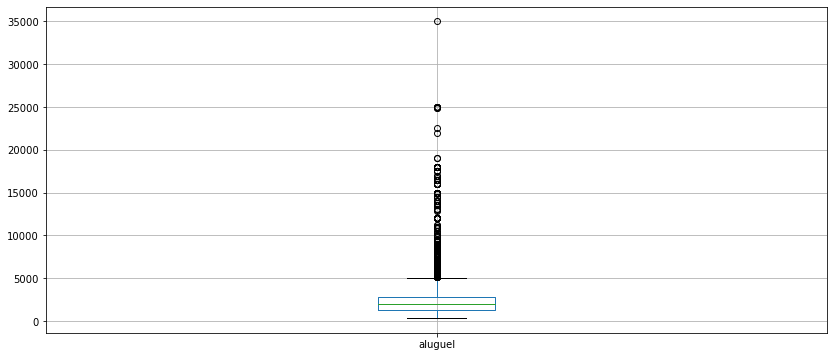

In [27]:
# Primeira avaliação da distribuição

base_final.boxplot(['aluguel'])

In [28]:
# Verificando quantidade de itens com aluguel >= 10.000,00

base_final[base_final['aluguel'] > 10000]

,descricao_imovel,aluguel,condominio,total_mensal,iptu,metragem,endereco,bairro,cidade,zona,quartos,banheiros,garagem
559,"Apartamento com 153,99m² privativos, mobiliado...",12000,1500,13500,550,154,Não Informado,Auxiliadora,Porto Alegre,Zona Norte,3,4,2
1235,PARIGI Imóveis aluga apartamento com 03 suítes...,18000,1298,19298,0,179,Não Informado,Bela Vista,Porto Alegre,Centro,3,5,3
1278,RESIDENCE IMÓVEIS VENDE OU ALUGA espetacular a...,22500,5000,27500,2000,373,Não Informado,Auxiliadora,Porto Alegre,Zona Norte,3,3,4
1324,EXCLUSIVIDADE MULTI IMOB! Apartamento com 158...,11000,1400,12400,300,158,Não Informado,Petrópolis,Porto Alegre,Centro,3,4,4
1727,"Apartamento com 153,99m² privativos, mobiliado...",12000,1500,13500,550,154,Não Informado,Auxiliadora,Porto Alegre,Zona Norte,3,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7286,RESIDENCE IMÓVEIS VENDE E ALUGA Apartamento co...,16500,2000,18500,1000,205,Não Informado,Bela Vista,Porto Alegre,Centro,3,3,3
7287,Impecável apartamento totalmente reformado e d...,15000,2200,17200,6000,252,Não Informado,Moinhos de Vento,Porto Alegre,Centro,3,5,2
7289,Apartamento semi mobiliado de 3 dormitórios e ...,12800,2000,14800,615,204,Não Informado,Bela Vista,Porto Alegre,Centro,3,4,2
7290,Lindíssima cobertura no bairro Bela Vista. Imó...,16700,1800,18500,2260,463,Rua Doutor Tauphick Saadi,Bela Vista,Porto Alegre,Centro,3,5,4


In [29]:
# Definindo os quartis e limites

valor = base_final['aluguel']

Q1 = valor.quantile(.25)
Q3 = valor.quantile(.75)
IIQ = Q3 - Q1
limite_inferior = Q1 - 1.5 * IIQ
limite_superior = Q3 + 1.5 * IIQ

In [30]:
# Aplicando a definição dos limites para remoção dos outliers e definindo o novo dataset

selecao = (valor >= limite_inferior) & (valor <= limite_superior)
dataset = base_final[selecao].reset_index(drop=True)

In [31]:
print('Ao todo, foram excluídas {} linhas.'.format(base_final.shape[0] - dataset.shape[0]))

Ao todo, foram excluídas 507 linhas.


<AxesSubplot:>

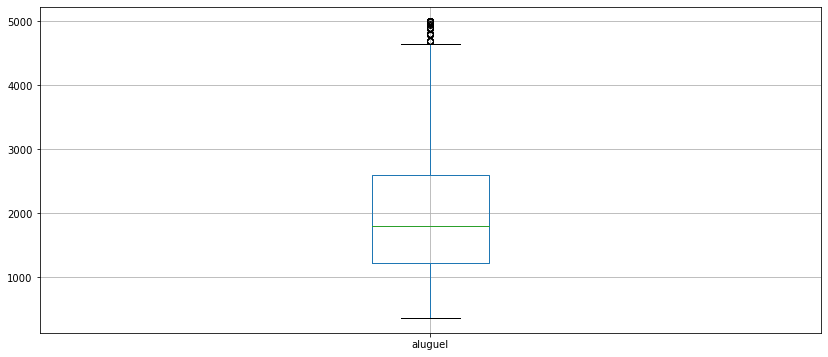

In [32]:
# Avaliação da distribuição após remoção dos outliers

dataset.boxplot(['aluguel'])

array([[<AxesSubplot:title={'center':'aluguel'}>]], dtype=object)

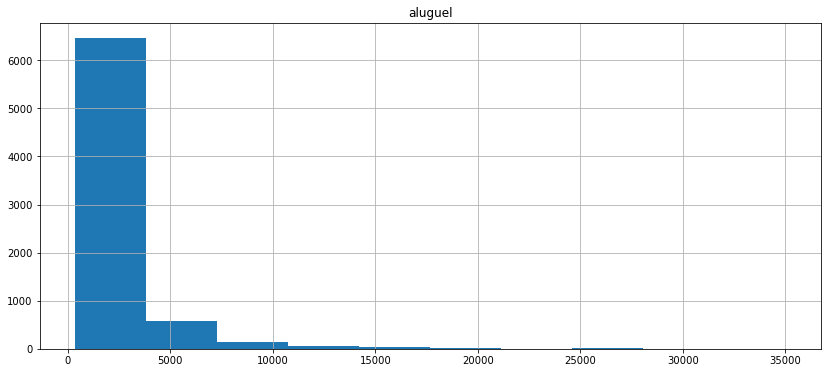

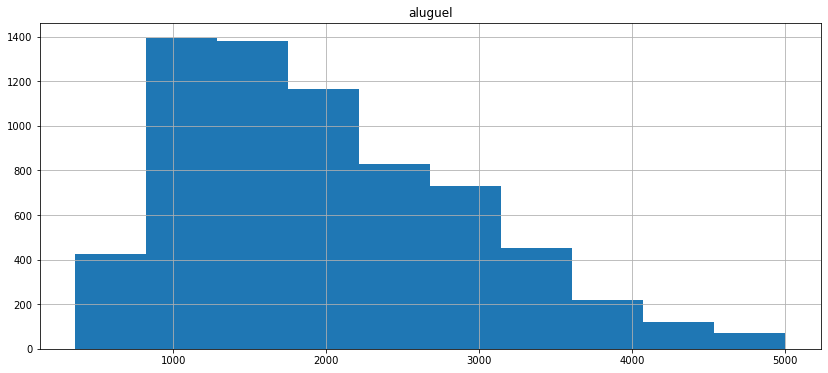

In [33]:
# Avaliação dos histogramas antes e depois da remoção dos outliers

base_final.hist(['aluguel'])
dataset.hist(['aluguel'])

In [34]:
dataset.tail()

,descricao_imovel,aluguel,condominio,total_mensal,iptu,metragem,endereco,bairro,cidade,zona,quartos,banheiros,garagem
6781,"SALA, COZINHA, BANHEIRO SOCIAL, 1 AREA DE SERV...",3000,1670,4670,283,183,Não Informado,Centro Histórico,Porto Alegre,Centro,3,1,0
6782,Apartamento garden com 477m² no bairro Farroup...,3500,2100,5600,5000,477,Não Informado,Farroupilha,Porto Alegre,Centro,3,3,1
6783,Leindecker Imóveis aluga apartamento com 193m²...,3200,2061,5261,0,193,Avenida Independência,Independência,Porto Alegre,Centro,3,3,2
6784,"Poa imob aluga apartamento com 3 dormitórios, ...",2350,2300,4650,0,60,Avenida Bento Gonçalves,Partenon,Porto Alegre,Zona Sul,3,2,0
6785,"Apartamento para Aluguel - Centro Histórico, 2...",5000,3200,8200,250,400,Rua General Andrade Neves,Centro Histórico,Porto Alegre,Centro,2,4,0


In [35]:
# Avaliando número de itens e colunas após limpeza dos dados

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6786 entries, 0 to 6785
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   descricao_imovel  6786 non-null   object
 1   aluguel           6786 non-null   int64 
 2   condominio        6786 non-null   int64 
 3   total_mensal      6786 non-null   int64 
 4   iptu              6786 non-null   int64 
 5   metragem          6786 non-null   int64 
 6   endereco          6786 non-null   object
 7   bairro            6786 non-null   object
 8   cidade            6786 non-null   object
 9   zona              6786 non-null   object
 10  quartos           6786 non-null   int64 
 11  banheiros         6786 non-null   int64 
 12  garagem           6786 non-null   int64 
dtypes: int64(8), object(5)
memory usage: 689.3+ KB


In [36]:
# Avaliando as variáveis numéricas após limpeza dos dados

dataset.describe().round()

,aluguel,condominio,total_mensal,iptu,metragem,quartos,banheiros,garagem
count,6786.0,6786.0,6786.0,6786.0,6786.0,6786.0,6786.0,6786.0
mean,1997.0,458.0,2455.0,139.0,74.0,2.0,1.0,1.0
std,939.0,293.0,1118.0,1313.0,27.0,0.0,1.0,1.0
min,360.0,0.0,580.0,0.0,10.0,2.0,1.0,0.0
25%,1216.0,280.0,1550.0,33.0,58.0,2.0,1.0,0.0
50%,1800.0,400.0,2273.0,70.0,68.0,2.0,1.0,1.0
75%,2600.0,570.0,3155.0,131.0,84.0,3.0,2.0,1.0
max,5000.0,3500.0,8200.0,106000.0,477.0,3.0,5.0,6.0


# Análise Exploratória

In [37]:
dataset.head()

,descricao_imovel,aluguel,condominio,total_mensal,iptu,metragem,endereco,bairro,cidade,zona,quartos,banheiros,garagem
0,"Apartamento com 77m² no bairro Boa Vista, em P...",4000,790,4790,235,77,Não Informado,Boa Vista,Porto Alegre,Zona Norte,2,3,2
1,Porto do Sol Imóveis ALUGA excelente apartamen...,2500,908,3408,177,76,Avenida Independência,Independência,Porto Alegre,Centro,2,1,1
2,"Apartamento para Aluguel - Menino Deus, 2 Quar...",2000,455,2455,100,60,Rua José de Alencar,Menino Deus,Porto Alegre,Centro,2,1,1
3,"Apartamento para Aluguel - Menino Deus, 2 Quar...",1490,320,1810,92,60,Rua Almirante Gonçalves,Menino Deus,Porto Alegre,Centro,2,1,1
4,"Apartamento para Aluguel - Tristeza, 2 Quartos...",2000,500,2500,58,51,Rua General Rondon,Tristeza,Porto Alegre,Zona Sul,2,1,1



### Média de aluguel, condomínio e total mensal para apartamentos de 2 e 3 quartos

In [38]:
# Definindo o dataset

media_quartos = dataset.groupby(['quartos']).agg({'total_mensal':'mean'}).sort_values(by='total_mensal', ascending=False).reset_index().round()
media_quartos

,quartos,total_mensal
0,3,3090.0
1,2,2224.0


In [39]:
# Definindo a função plotar_gráfico

def plotar_grafico(titulo, labelx, x, y, dataset):
    fig, ax = plt.subplots(figsize=(5,5))
    sns.barplot(x = x, y = y, data = dataset, ci = None, palette='Set2_r')
    ax.set_frame_on(False)
    ax.set_title(titulo, fontdict={'fontsize':15})
    ax.set_xlabel(labelx, fontdict={'fontsize':15})
    ax.get_yaxis().set_visible(False)
    ax.tick_params(axis='x',length=0,labelsize=12,colors='dimgrey')
    sns.color_palette("flare", as_cmap=True)
    for retangulo in ax.patches:
      ax.text(retangulo.get_x() + retangulo.get_width() / 2,
              retangulo.get_height() + 25,
              '{:,}'.format(int(retangulo.get_height())).replace(',','.'),
              ha = 'center',
              fontsize=12)
    plt.tight_layout();

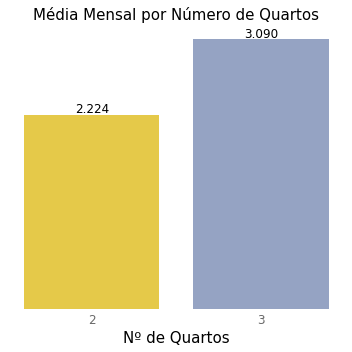

In [40]:
# Plotando o gráfico

grafico_1 = plotar_grafico('Média Mensal por Número de Quartos', 'Nº de Quartos', 'quartos', 'total_mensal', media_quartos)

### Média de total mensal por zona

In [41]:
# Definindo o dataset

media_zonas = dataset.groupby(['zona']).agg({'total_mensal':'mean'}).sort_values(by='total_mensal', ascending=False).reset_index().round()
media_zonas

,zona,total_mensal
0,Centro,2819.0
1,Zona Leste,2353.0
2,Zona Norte,2267.0
3,Zona Sul,2000.0


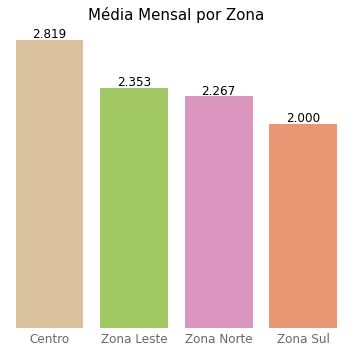

In [42]:
# Plotando o gráfico

grafico_2 = plotar_grafico('Média Mensal por Zona', '', 'zona', 'total_mensal', media_zonas)

### Separando a média mensal por zona pelo número de quartos

In [43]:
# Definindo o dataset

por_quartos = dataset[['zona', 'total_mensal', 'quartos']].reset_index(drop=True)

# Estabelecendo o dataset por_quartos_zona para uso na dashboard posteriormente

por_quartos_zona = por_quartos.groupby(['zona', 'quartos']).agg({'total_mensal':'mean'}).reset_index().round()

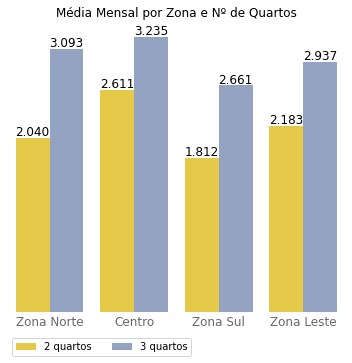

In [44]:
# Plotando o gráfico

def plotar_grafico_legenda(titulo, labelx, x, y, dataset):
    fig, ax = plt.subplots(figsize=(5,5))
    sns.barplot(x = x, y = y, data = dataset, ci = None, palette='Set2_r', hue = 'quartos')
    ax.set_frame_on(False)
    ax.set_title(titulo, fontdict={'fontsize':12})
    ax.set_xlabel(labelx, fontdict={'fontsize':12})
    ax.get_yaxis().set_visible(False)
    ax.tick_params(axis='x',length=0,labelsize=12,colors='dimgrey')
    sns.color_palette("flare", as_cmap=True)
    for retangulo in ax.patches:
        ax.text(retangulo.get_x() + retangulo.get_width() / 2,
                retangulo.get_height() + 25,
                '{:,}'.format(int(retangulo.get_height())).replace(',','.'),
                ha = 'center',
                fontsize=12)
    plt.tight_layout();
    plt.legend(ncol = 2, loc = 'lower left', bbox_to_anchor = (0,-0.17), labels=['2 quartos','3 quartos'])
    
grafico_3 = plotar_grafico_legenda('Média Mensal por Zona e Nº de Quartos', ' ', 'zona', 'total_mensal', por_quartos)


### Média Mensal dos bairros da zona Centro

In [45]:
# Definindo a função plotar_gráfico_maior

def plotar_grafico_maior(titulo, labelx, x, y, data):
    fig, ax = plt.subplots(figsize=(25,5))
    sns.barplot(x = x, y = y, data = data, ci = None, palette = 'Set2_r')
    ax.set_frame_on(False)
    ax.set_title(titulo, fontdict={'fontsize':15})
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel(labelx, fontdict={'fontsize':15})
    ax.tick_params(axis='x',length=0,labelsize=12,colors='dimgrey')
    for retangulo in ax.patches:
      ax.text(retangulo.get_x() + retangulo.get_width() / 2,
              retangulo.get_height() + 25,
              '{:,}'.format(int(retangulo.get_height())).replace(',','.'),
              ha = 'center',
              fontsize=12)
    plt.tight_layout();

In [46]:
# Definindo o dataset

media_centro = dataset[dataset['zona'] == 'Centro'].reset_index(drop=True)
media_centro_dois_quartos = media_centro[media_centro['quartos'] == 2].reset_index(drop=True)
media_centro_tres_quartos = media_centro[media_centro['quartos'] == 3].reset_index(drop=True)

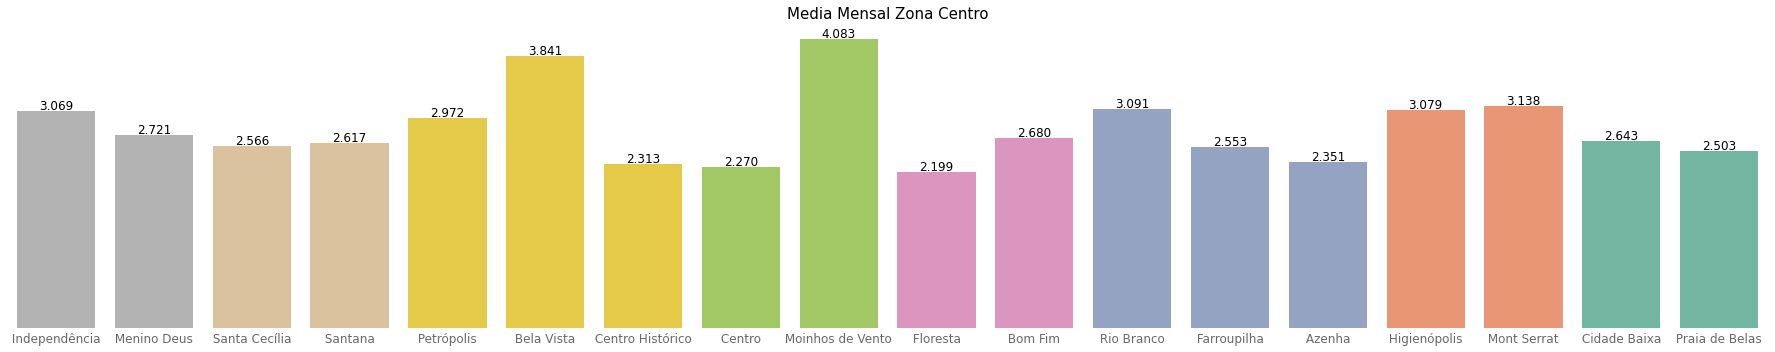

In [47]:
# Plotando o gráfico Média de apartamentos bairro da zona Centro

grafico_4 = plotar_grafico_maior('Media Mensal Zona Centro', '', 'bairro', 'total_mensal', media_centro)

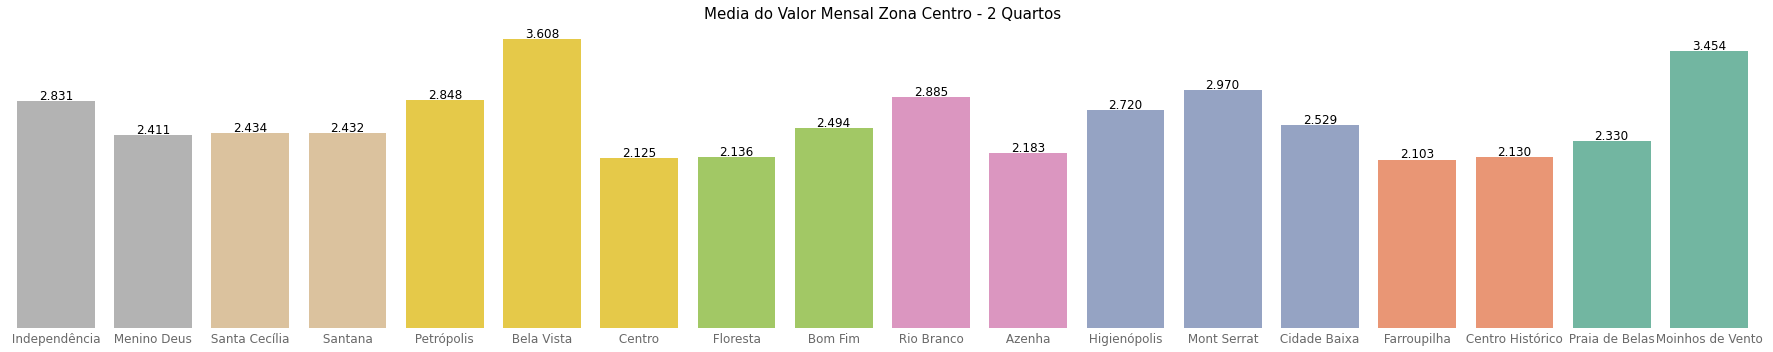

In [48]:
# Plotando o gráfico Média de apartamentos com 2 quartos por bairro da zona Centro

grafico_5 = plotar_grafico_maior('Media do Valor Mensal Zona Centro - 2 Quartos', '', 'bairro', 'total_mensal', media_centro_dois_quartos)

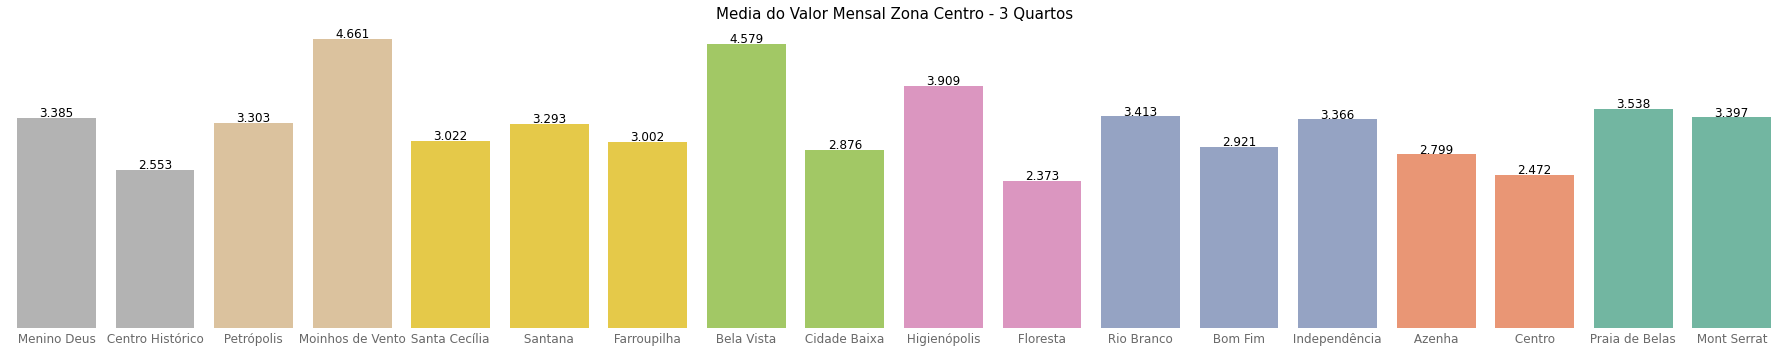

In [49]:
# Plotando o gráfico Média de apartamentos com 3 quartos por bairro da zona Centro

grafico_6 = plotar_grafico_maior('Media do Valor Mensal Zona Centro - 3 Quartos', '', 'bairro', 'total_mensal', media_centro_tres_quartos)

### Listar apartamentos na zona Centro com 2 quartos e metragem >= 70m²

In [50]:
# Definindo o dataset

setenta = dataset[(dataset['zona'] == 'Centro') & (dataset['metragem'] >= 70) & (dataset['quartos'] == 2)][['total_mensal', 'bairro']].reset_index(drop=True)

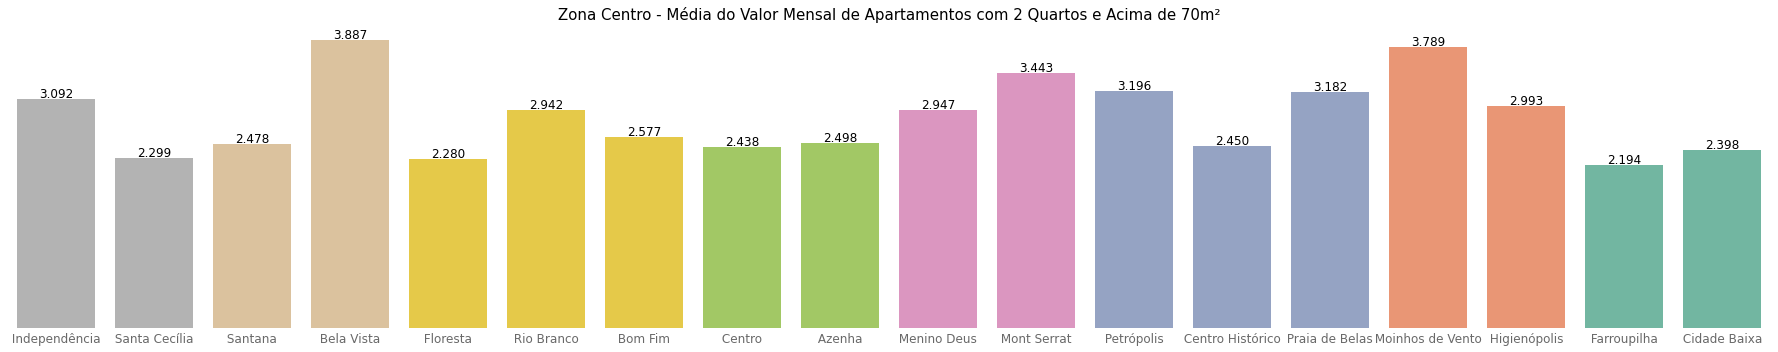

In [51]:
# Plotando o gráfico 

grafico_7 = plotar_grafico_maior('Zona Centro - Média do Valor Mensal de Apartamentos com 2 Quartos e Acima de 70m²', '', 'bairro', 'total_mensal', setenta)

### Listar apartamentos com 3 quartos e metragem >= 80m²

In [52]:
# Definindo o dataset

oitenta = dataset[(dataset['zona'] == 'Centro') & (dataset['metragem'] >= 80) & (dataset['quartos'] == 3)][['total_mensal', 'bairro']].reset_index(drop=True)

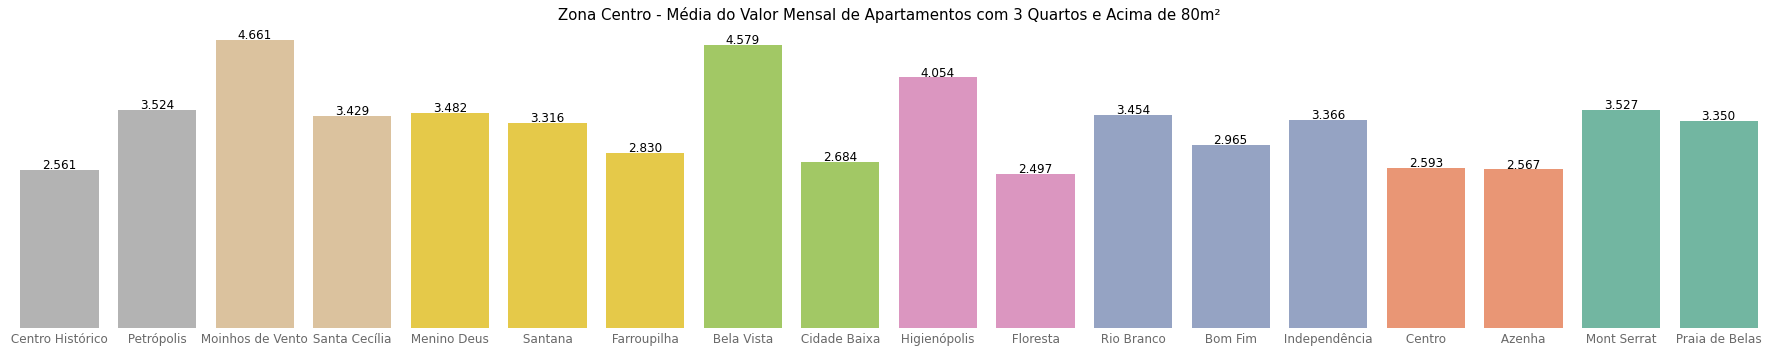

In [53]:
# Plotando o gráfico 

grafico_8 = plotar_grafico_maior('Zona Centro - Média do Valor Mensal de Apartamentos com 3 Quartos e Acima de 80m²', '', 'bairro', 'total_mensal', oitenta)

### Identificando os apartamentos de 2 quartos com metragem >= 100m² e total mensal até 3.000,00

<AxesSubplot:>

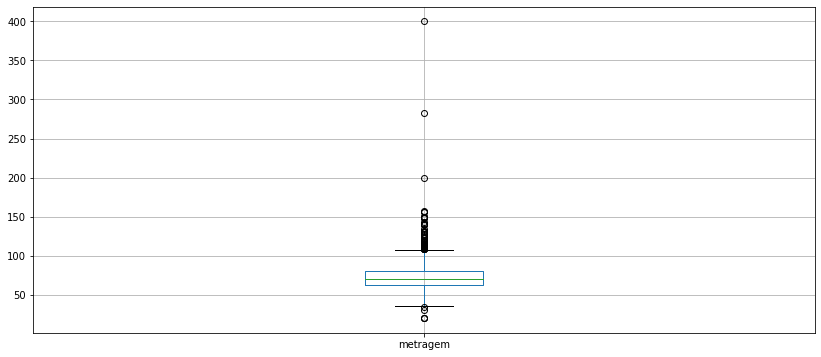

In [54]:
# Primeira avaliação da distribuição de metragem

media_centro_dois_quartos.boxplot(['metragem'])

In [55]:
# Definindo o Dataset

centro_2q_100m = media_centro_dois_quartos[(media_centro_dois_quartos['metragem'] >= 100) & (media_centro_dois_quartos['total_mensal'] <= 3000)].reset_index(drop=True)
centro_2q_100m.tail()

,descricao_imovel,aluguel,condominio,total_mensal,iptu,metragem,endereco,bairro,cidade,zona,quartos,banheiros,garagem
42,"Apartamento para Aluguel - Santana, 2 Quartos,...",1926,250,2176,0,100,Rua Delegado Grant,Santana,Porto Alegre,Centro,2,1,0
43,Apartamento no bairro Centro Histórico com 110...,2000,800,2800,255,110,Rua Siqueira Campos,Centro Histórico,Porto Alegre,Centro,2,2,0
44,Apartamento no bairro Centro Histórico com 110...,2000,800,2800,255,110,Rua Siqueira Campos,Centro Histórico,Porto Alegre,Centro,2,2,0
45,"Apartamento com 2 dormitórios para alugar, 100...",2500,400,2900,50,100,Rua Delegado Grant,Santana,Porto Alegre,Centro,2,1,0
46,"[ Alugue este imóvel sem fiador, sem burocraci...",1300,483,1783,130,102,Rua Marechal Floriano Peixoto,Centro Histórico,Porto Alegre,Centro,2,1,0


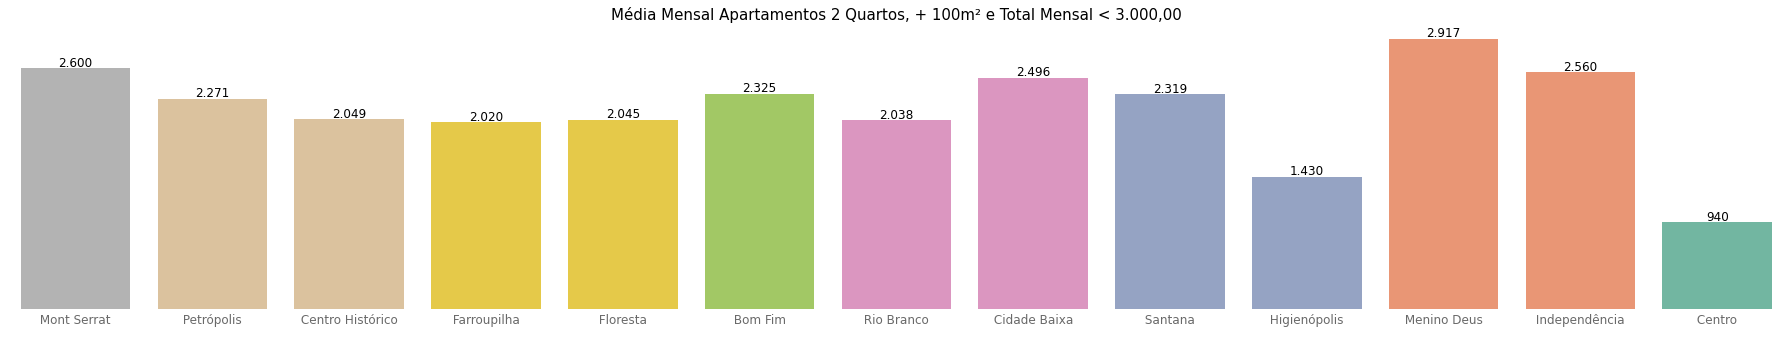

In [56]:
# Plotando o gráfico por bairro

grafico_9 = plotar_grafico_maior('Média Mensal Apartamentos 2 Quartos, + 100m² e Total Mensal < 3.000,00', ' ', 'bairro', 'total_mensal', centro_2q_100m)


# Salvando o DataFrame no formato .csv

In [57]:
dataset.to_csv('dataset.csv', index = False, encoding = 'utf-8-sig')